<a href="https://colab.research.google.com/github/deniskapel/GenerativeChitChat/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
mkdir data
mkdir pretrained
mkdir model
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uSgX8EaXtSR1yZgs-pJGYiZXi7tPEBrE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uSgX8EaXtSR1yZgs-pJGYiZXi7tPEBrE" -O data/qa_data.jsonl.zip && rm -rf /tmp/cookies.txt
unzip data/qa_data.jsonl.zip -d data

In [ ]:
%%bash
wget "https://raw.githubusercontent.com/deniskapel/GenerativeChitChat/master/requirements.txt"
pip install -r requirements.txt

In [217]:
import codecs
import json
import random
import math

import numpy as np
import pandas as pd

import json
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [4]:
assert torch.cuda.is_available(), 'no gpu available'
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
%%bash
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QALzCQV3awJ84_LAVoo1FTdZ65VHX8Mc' -O pretrained/my_pretrained_bpe_lm.model

In [6]:
tokenizer = yttm.BPE(model="pretrained/my_pretrained_bpe_lm.model")

In [7]:
batch_size = 64
pad_index = 0
eos_index = 3
vocab_size=30_000

## Data

In [8]:
!sed 5q data/qa_data.jsonl

{"question": "долго ли идут деньги с яндексденег на карту visa?", "category": "Бизнес, Финансы", "responses": ["нет. прорыв 35 ;)"]}
{"question": "можно ли зарегистрировать авто в другом регионе", "category": "Авто, Мото", "responses": ["можно на родственника из того региона.. .  а потом ездить по доверке"]}
{"question": "что делать если у меня очень тонкие ногти а хочется их отрастить?", "category": "Красота и Здоровье", "responses": ["витамины и умная эмаль (каждый день)", "ванночки с морской солью. с вечера мажь ногти сверху йодом. не бойся, до утра все впитается.", "умная эмаль, витамины, йод, и поменьше крась лаком ", "лаки фирмы trind производство usa + кальций"]}
{"question": "в чем отличие медитации от йоги?", "category": "Спорт", "responses": ["букв в йоге меньше", "в медитации ты просто сидишь и мммммычишь. а в йоге всяко разные упражнения вытворяешь", "в медитации вроде просто тупо сидишь и успокаеваешься, а в йоге еще и ноги за уши закидывать надо"]}
{"question": "когда нач

In [9]:
with codecs.open("data/qa_data.jsonl", encoding='utf-8-sig') as reader:
    lines = reader.read().split("\n")
    lines = list(map(json.loads, filter(None, lines)))

data = []
for line in tqdm(lines):
    for response in line['responses']:
        data.append(
            {'question': line['question'].lower(),
             'category': line['category'],
             'response': response.lower()})

del lines
df = pd.json_normalize(data)
del data

  0%|          | 0/2808811 [00:00<?, ?it/s]

In [10]:
df.head()

,question,category,response
0,долго ли идут деньги с яндексденег на карту visa?,"Бизнес, Финансы",нет. прорыв 35 ;)
1,можно ли зарегистрировать авто в другом регионе,"Авто, Мото",можно на родственника из того региона.. . а п...
2,что делать если у меня очень тонкие ногти а хо...,Красота и Здоровье,витамины и умная эмаль (каждый день)
3,что делать если у меня очень тонкие ногти а хо...,Красота и Здоровье,ванночки с морской солью. с вечера мажь ногти ...
4,что делать если у меня очень тонкие ногти а хо...,Красота и Здоровье,"умная эмаль, витамины, йод, и поменьше крась л..."


In [165]:
df.shape

(7767138, 3)

In [253]:
df_mini = df.sample(frac=0.01, random_state=42)
train_df = df_mini.sample(frac=0.8,random_state=42)
val_df = df_mini.drop(train_df.index)
test_df = val_df.sample(frac=0.5,random_state=42)
val_df = val_df.drop(test_df.index)

In [254]:
train_df.category.value_counts()

Знакомства, Любовь, Отношения    7978
Философия, Непознанное           7098
Семья, Дом, Дети                 6282
Красота и Здоровье               5233
Искусство и Культура             5192
Авто, Мото                       4711
Спорт                            3984
Животные, Растения               3808
Досуг, Развлечения               3320
Еда, Кулинария                   2804
Стиль, Мода, Звезды              2744
Бизнес, Финансы                  2366
Путешествия, Туризм              2298
Работа, Карьера                  2287
Образование                      2032
Name: category, dtype: int64

### Datasets

In [255]:
class QAData(torch.utils.data.Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer,
                 pad_index=0, eos_index=3, response_len=32):
        
        self.x = data.question.tolist()
        self.y = data.response.tolist()
        self.tokenizer = tokenizer
        # to use with beam search later
        self.categories = data.category.tolist()
        self.response_maxlen = response_len
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        """ x is a question and y is an asnwer """
        x = self.tokenizer.encode(self.x[index], bos=True, eos=True)
        y = self.tokenizer.encode(self.y[index], bos=True, eos=True)

        # different shape of samples is handled by batch_sampler and encoder/decoder
        x = torch.Tensor(x).type(torch.long)
        y = torch.Tensor(y).type(torch.long)
        
        return x, y 

    def collate_batch(self, batch):
        """
        add padding to dynamically match the longest sample in a batch
        """
        batch_x, batch_y = self.__group_samples(batch)

        batch_x = pad_sequence(batch_x, padding_value=self.pad_index, batch_first=True)
        batch_y = pad_sequence(batch_y, padding_value=self.pad_index, batch_first=True)

        return batch_x, batch_y

    def __group_samples(self, batch: list) -> list:
        """ 
        input: [(sample_1_x, sample_1_y), (sample_2_x, sample_2_y)]
        output: [[samle_1_x, sample_2_x], [sample_1_y, sample_2_y]]
        """
        batch_x = []
        batch_y = []
        for sample in batch:
            batch_x.append(sample[0])
            batch_y.append(sample[1])

        return batch_x, batch_y

In [256]:
train_dataset = QAData(
    data=train_df,
    tokenizer=tokenizer)

val_dataset = QAData(
    data=val_df,
    tokenizer=tokenizer)

test_dataset = QAData(
    data=test_df,
    tokenizer=tokenizer)

len(train_dataset), len(val_dataset), len(test_dataset)

(62137, 7767, 7767)

### DataLoader

In [257]:
class Sampler():
    def __init__(self, dataset, batch_size=64):
        self.dataset = dataset
        self.n_batches = len(dataset) // batch_size
        self.batch_size = batch_size

    def __iter__(self):
        indices = [(i, len(s[0])) for i, s in enumerate(self.dataset)]
        random.shuffle(indices)
        pooled_indices = []
        # create pool of indices with similar lengths 
        for i in range(0, len(indices), batch_size * 100):
            pooled_indices.extend(
                sorted(indices[i:i + batch_size * 100], key=lambda x: x[1])
                )
        pooled_indices = [x[0] for x in pooled_indices]
        
        # yield indices for current batch
        for i in range(0, len(pooled_indices), batch_size):
            yield pooled_indices[i:i + batch_size]

train_sampler = Sampler(train_dataset)
val_sampler = Sampler(val_dataset)
test_sampler = Sampler(test_dataset)

In [258]:
train_loader = DataLoader(
    train_dataset,
    collate_fn=train_dataset.collate_batch,
    batch_sampler=train_sampler)

val_loader = DataLoader(
    val_dataset,
    collate_fn=val_dataset.collate_batch,
    batch_sampler=val_sampler)

test_loader = DataLoader(
    test_dataset,
    collate_fn=val_dataset.collate_batch,
    batch_sampler=test_sampler)

In [259]:
for batch in train_loader:
    break

batch[0].shape, batch[1].shape

(torch.Size([64, 5]), torch.Size([64, 26]))

In [260]:
train_sampler.n_batches,val_sampler.n_batches,test_sampler.n_batches

(970, 121, 121)

In [261]:
progress_bar = tqdm(total=len(train_loader.dataset), desc='Testing')

for x, y in train_loader:
    progress_bar.update(x.size(0))
    
progress_bar.close()

Testing:   0%|          | 0/62137 [00:00<?, ?it/s]

In [262]:
progress_bar = tqdm(total=len(val_loader.dataset), desc='Testing')

for x, y in val_loader:
    progress_bar.update(x.size(0))
    
progress_bar.close()

Testing:   0%|          | 0/7767 [00:00<?, ?it/s]

In [263]:
progress_bar = tqdm(total=len(test_loader.dataset), desc='Testing')

for x, y in test_loader:
    progress_bar.update(x.size(0))
    
progress_bar.close()

Testing:   0%|          | 0/7767 [00:00<?, ?it/s]

In [264]:
batch[0].shape, batch[1].shape

(torch.Size([64, 5]), torch.Size([64, 26]))

## Model

### Encoder/Decoder

In [265]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, enc_hs, dec_hs, 
                 dropout=0, vocab_size=30_000, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=emb_dim,
                                      padding_idx=padding_idx)
        self.rnn = nn.GRU(emb_dim, enc_hs, bidirectional = True, batch_first=True)
        self.fc = nn.Linear(enc_hs * 2, dec_hs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden=None):
        embedded = self.embedding(input)
        outputs, hidden = self.rnn(embedded, hidden)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hs, dec_hs):
        super().__init__()
        
        self.attn = nn.Linear((enc_hs * 2) + dec_hs, dec_hs)
        self.v = nn.Linear(dec_hs, 1, bias = False)
        
    def forward(self, encoder_outputs, hidden):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, emb_dim, enc_hs, dec_hs, 
                 attention, dropout=0, 
                 vocab_size=30_000, padding_idx=0):
        super().__init__()
        self.output_dim = vocab_size
        self.attention = attention
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=emb_dim,
                                      padding_idx=padding_idx)
        self.rnn = nn.GRU((enc_hs * 2) + emb_dim, dec_hs)
        self.fc_out = nn.Linear((enc_hs * 2) + dec_hs + emb_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, encoder_outputs, hidden):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(encoder_outputs, hidden)
        a = a.unsqueeze(1)

        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

In [266]:
encoder = Encoder(emb_dim=512, enc_hs = 128, dec_hs=128)
attn = Attention(enc_hs = 128, dec_hs=128)
decoder = Decoder(emb_dim=512, enc_hs = 128, dec_hs=128,
                  attention=Attention(enc_hs = 128, dec_hs=128))

In [267]:
output, hidden = encoder.forward(input=batch[0])
att_energy = attn.forward(output, hidden=hidden)
dec_output, dec_hidden = decoder.forward(batch[1][:,0], output, hidden)
dec_output, dec_hidden = decoder.forward(batch[1][:,1], output, hidden)

In [268]:
output.shape, hidden.shape, att_energy.shape, dec_output.shape, batch[1][:,1].shape

(torch.Size([64, 5, 256]),
 torch.Size([64, 128]),
 torch.Size([64, 5]),
 torch.Size([64, 30000]),
 torch.Size([64]))

In [269]:
class QAmodel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, questions, responses, teacher_forcing_ratio = 0.5):
        
        batch_size = questions.shape[0]
        trg_len = responses.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        # create dummy tensor to store output sequence and put in to gpu
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(questions)
                
        #first input to the decoder is the <sos> tokens
        input = responses[:,0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, encoder_outputs, hidden)
            outputs[:,t,:] = output
            input = output.argmax(1) 

        return outputs

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512

attention_layer = Attention(ENC_HID_DIM, DEC_HID_DIM)
encoder = Encoder(ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM)
decoder = Decoder(DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, attention_layer)


In [270]:
model = QAmodel(encoder, decoder, 'cpu')

with torch.no_grad():
    pred = model.forward(batch[0], batch[1])

pred.shape

torch.Size([64, 26, 30000])

In [271]:
model = QAmodel(encoder, decoder, device)
model.to(device)

QAmodel(
  (encoder): Encoder(
    (embedding): Embedding(30000, 256, padding_idx=0)
    (rnn): GRU(256, 512, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(30000, 256, padding_idx=0)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=30000, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [272]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Количество обучаемых параметров в сети: {count_parameters(model):,}')

Количество обучаемых параметров в сети: 75,583,280


## Train

In [273]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = pad_index)

In [274]:
def train(model, loader, criterion, optimizer, n_batches, 
          clip=3., last_n_losses=500, verbose=True):

    losses = []
    progress_bar = tqdm(total=n_batches, disable=not verbose, desc='Train')
    model.train()

    for x, y in loader:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x, y)

        # Compare (batch_size,vocab_size,seq_len) with (batch_size, seq_len)
        loss = criterion(pred.transpose(1,2), y)

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses


def evaluate(model, loader, criterion, n_batches, last_n_losses=500, verbose=True):
    
    losses = []

    n_batches

    progress_bar = tqdm(total=n_batches, disable=not verbose, desc='Evaluate')

    model.eval()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model(x, y)

        # Compare (batch_size,vocab_size,seq_len) with (batch_size, seq_len)
        loss = criterion(pred.transpose(1,2), y)

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [275]:
epochs = 10

train_losses = []
validation_losses = []

train_perplexities = []
validation_perplexities = []

best_validation_loss = 1e+6

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses = train(
        model, train_loader, criterion, optimizer, train_sampler.n_batches)
    epoch_validation_losses = evaluate(
        model, val_loader, criterion, val_sampler.n_batches)
    
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_perplexities.append(np.exp(mean_train_loss))
    
    validation_losses.append(epoch_validation_losses)
    validation_perplexities.append(np.exp(mean_validation_loss))
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | perplexity - {train_perplexities[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | perplexity - {validation_perplexities[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'model/best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'model/best_optimizer_state_dict.pth')
        
    else:
        break
        
    torch.save(model.state_dict(), f'model/last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'model/last_optimizer_state_dict.pth')

    with open(f'model/info_{n_epoch}.json', 'w') as file_object:

        info = {
            'message': message,
            'train_losses': train_losses,
            'validation_losses': validation_losses,
            'train_perplexities': train_perplexities,
            'validation_perplexities': validation_perplexities
        }

        file_object.write(json.dumps(info, indent=2))

Train:   0%|          | 0/970 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 1
Train: loss - 8.2510 | perplexity - 3831.567
Validation: loss - 8.1178 | perplexity - 3353.684


Train:   0%|          | 0/970 [00:00<?, ?it/s]

Evaluate:   0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 2
Train: loss - 7.6586 | perplexity - 2118.685
Validation: loss - 8.2094 | perplexity - 3675.423


In [242]:
for x, y in test_loader:
    break

x.shape, y.shape

(torch.Size([64, 7]), torch.Size([64, 33]))

In [279]:
def generate(x, y, bos_index=2, eos_index=3, max_sequence=512):
    
    model.eval()
    # мы используем какой-нибудь seed text для того, по нему предсказать продолжение
    with torch.no_grad():

        # получим представления модели от нашего сид текста
        x = x.to(device)
        y = y.to(device)
        
        preds = model(x, y)
        preds = nn.Softmax(dim=-1)(preds).argmax(-1).cpu().numpy()
        
        questions = tokenizer.decode(x.detach().tolist(), ignore_ids=[0,1,2,3])
        responses = tokenizer.decode(preds.tolist(), ignore_ids=[0,1,2,3])

        return questions, responses

qs, rs = generate(x, y)

for q, r in zip(qs, rs):
    print(q, " - ", r , '\n')

как дожить до вечера, если с самого утра все наперекосяк? документы- рассыпаются, ножи- режутся, а остальное- ломается  -  а не не не 

про эко..."дети — это дар божий. и если вам не дано стать матерью, не стоит и пытаться." согласны?? вн  -  а не не не не 

аниме "атака на титанов". первый сезон я уже не помню, что такого случилось с леви, что весь второй сезон он не воевал?  -  а не не не 

друзья! вот если меня сейчас увидеть, то рука обожжена, палец на ноге синий от ушиба и мы детей ругаем! а вы как выглядите  -  а не не не 

в сумке трудно найти чтто-либо,даже с помощью собак и фонарика))).пока ищешь телефон, он умолкает. а у вас ?  -  в в в в 

гляжу в окошко, на соседней крыше загорают две девушки-"крышным загаром")),а вы каким загаром загораете?)))  -  я в в не 

спарнем не встретилась была причина! потом позвонила извинилась общались, но он стал холодным, а теперьсидит в онлайне и не  -  а что не не не 

меня пропустят в оаэ если на моем портфеле будет нарисована марихуана? кт

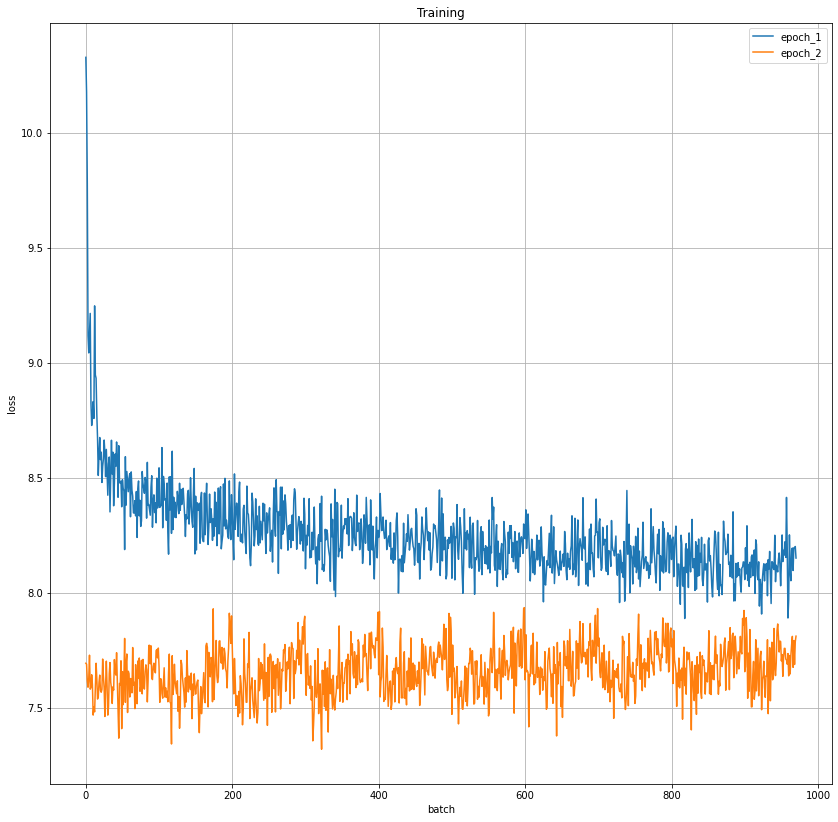

In [276]:
plt.figure(figsize=(14, 14))
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Training')

for i in range(len(train_losses)):
    label = f'epoch_{i+1}'
    plt.plot(train_losses[i], label=label)
    

plt.legend()
plt.grid()

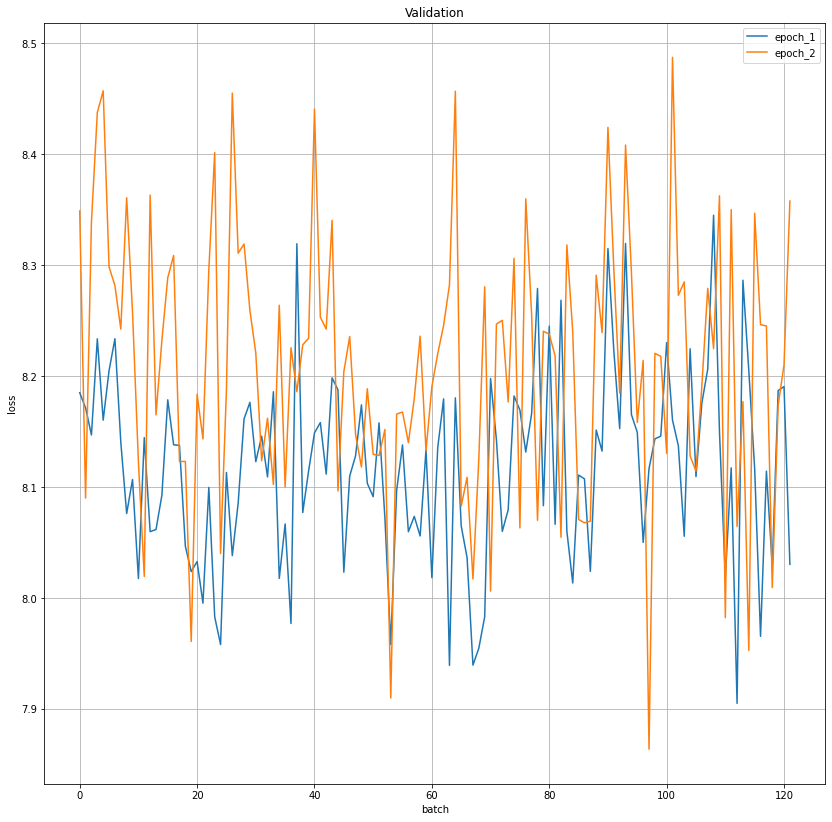

In [277]:
plt.figure(figsize=(14, 14))
plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Validation')

for i in range(len(validation_losses)):
    label = f'epoch_{i+1}'
    plt.plot(validation_losses[i], label=label)

plt.legend()
plt.grid()